# DeepFake Detection Challenge
### CompSci 175 Final Project
Group members: Yuchen Dai, Ziyi Liang

In [1]:
import cv2 # video frame extraction
from pathlib import Path
import numpy as np
import os, shutil, PIL, json, threading
import face_recognition
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, sampler

from torchvision import transforms, utils, models
import torchvision.datasets as dset
import torchvision.transforms as T

## Data Preprocessing

### Face Recognition using `face_recognition` module

In [2]:
class faceNotFoundException(Exception):
    pass

def extractFace(image) -> np.ndarray:
    face_coords= face_recognition.face_locations(image)
    if len(face_coords) == 0:
        raise faceNotFoundException
    face_coord = face_coords[0]
    x_lower = face_coord[0]
    x_upper = face_coord[2]
    y_lower = face_coord[3]
    y_upper = face_coord[1]
    croppedImage = image[x_lower:x_upper, y_lower: y_upper]
    return croppedImage

### Extract frame image from dataset

In [3]:
class MultithreadExtraction(threading.Thread):
    """Extract image using multithread"""
    def __init__(self, threadID, lock, *args):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.lock = lock
        self.args = args
        self.kill = False
    
    def run(self):
        self.extractAllFiles(*self.args)
        
    def extractAllFiles(self, videoFolderPath: str, imageFolderPath: str, startFrom = None):
        """
        startFrom: start extration from this mp4 file
        """
        fileCount = 0
        videoPath = Path(videoFolderPath)
        imagePath = Path(imageFolderPath)
        with open(videoFolderPath+ '\\metadata.json','r') as f:
            meta_data = json.load(f)
        print(f'<Thread ID {self.threadID}> Extracting from <{videoPath}> To <{imagePath}>')
        
        
        if imagePath.exists() and startFrom == None:
            print(f"<Thread ID {self.threadID}> Skipping pre-exist path: <{imagePath}>")
            return
        elif not imagePath.exists():
            os.mkdir(imageFolderPath)

        for file in videoPath.iterdir():
            if file.stem == 'metadata':
                continue # skip metadata.json file
            if meta_data[file.name]['label'] == 'FAKE':
                continue
            if startFrom and file.name <= startFrom:
                print(f'<Thread ID {self.threadID}> skipping file {file.name}')
                continue # skip all file before startFrom
                
#             self.lock.acquire()
#             print(f'<Thread ID {self.threadID}> acquire lock videoCapture')
            videoObject = cv2.VideoCapture(str(file))
#             self.lock.release()
#             print(f'<Thread ID {self.threadID}> release lock videoCapture')

            frameCount = 0
            croppedCount = 0
            success = True
            while success:                
                if self.kill:
                    print(f"<Thread ID {self.threadID}> Terminate before {file.name}")
                    return
                
                success, frame = videoObject.read()
                if not success:break
                try:
                    faceImage = extractFace(frame)
                except faceNotFoundException: # If no face is found in the image, continue execution
                    pass
                else: # If a face is found in the image, stop extracting images
                    croppedImageName = f"{imageFolderPath}\\{file.stem}_frame_{frameCount}_cropped_{croppedCount}_face.jpg"
                    
#                     self.lock.acquire()
#                     print(f'<Thread ID {self.threadID}> acquire lock imwrite')
                    cv2.imwrite(croppedImageName, faceImage)
                    croppedCount += 1
#                     self.lock.release()
#                     print(f'<Thread ID {self.threadID}> release lock imwrite')
                    if meta_data[file.name]['label'] == 'FAKE': # fake image only extract once
                        break
                    if croppedCount >= 10 and meta_data[file.name]['label'] == 'REAL': # extract ten real images 
                        break
                
                frameCount += 1

            fileCount += 1
            if fileCount % 10 == 0:
                print(f"<Thread ID {self.threadID}> {fileCount} files have been extracted")
                
        print(f"<Thread ID {self.threadID}> All files extraction complete")

In [6]:
threadLock = threading.Lock()
threads = []
cwd = os.getcwd()
for t in range(2,10):
    videoFolderPath = cwd + f"\\dfdc_train_part_0{t}\\dfdc_train_part_{t}\\"
    imageFolderPath = cwd + f"\\extraFrameExtraction\\part_{t}\\"
#     if t == 1:
#         threads.append(MultithreadExtraction(t, threadLock, videoFolderPath, imageFolderPath, "ubdkgejvtl.mp4"))
    threads.append(MultithreadExtraction(t, threadLock, videoFolderPath, imageFolderPath))

for t in threads:
    print(f"Start thread {t.threadID}")
    t.start()
    
while(1):
    cmd = input("Enter 'ALL' to kill all threads")
    if cmd == 'ALL':
        for t in threads:
            t.kill = True
            print(f'Attempt to kill thread {t.threadID}')
        break

for t in threads:
    print(f"Wait thread {t.threadID} to stop")
    t.join()
    print(f"Thread {t.threadID} has stopped")


Start thread 2
Start thread 3
Start thread 4
Start thread 5
Start thread 6
Start thread 7
Start thread 8
Start thread 9
<Thread ID 3> Extracting from <C:\Users\hower\virtualenv\finalProject\dfdc_train_part_03\dfdc_train_part_3> To <C:\Users\hower\virtualenv\finalProject\extraFrameExtraction\part_3>
<Thread ID 6> Extracting from <C:\Users\hower\virtualenv\finalProject\dfdc_train_part_06\dfdc_train_part_6> To <C:\Users\hower\virtualenv\finalProject\extraFrameExtraction\part_6><Thread ID 4> Extracting from <C:\Users\hower\virtualenv\finalProject\dfdc_train_part_04\dfdc_train_part_4> To <C:\Users\hower\virtualenv\finalProject\extraFrameExtraction\part_4><Thread ID 8> Extracting from <C:\Users\hower\virtualenv\finalProject\dfdc_train_part_08\dfdc_train_part_8> To <C:\Users\hower\virtualenv\finalProject\extraFrameExtraction\part_8>
<Thread ID 7> Extracting from <C:\Users\hower\virtualenv\finalProject\dfdc_train_part_07\dfdc_train_part_7> To <C:\Users\hower\virtualenv\finalProject\extraFrameE

<Thread ID 6> 200 files have been extracted
<Thread ID 5> 100 files have been extracted
<Thread ID 5> 110 files have been extracted
<Thread ID 2> 190 files have been extracted
<Thread ID 8> 270 files have been extracted
<Thread ID 8> All files extraction complete
<Thread ID 6> 210 files have been extracted
<Thread ID 2> 200 files have been extracted
<Thread ID 7> 120 files have been extracted
<Thread ID 2> 210 files have been extracted
<Thread ID 5> 120 files have been extracted
<Thread ID 6> 220 files have been extracted
<Thread ID 2> 220 files have been extracted
<Thread ID 7> 130 files have been extracted
<Thread ID 6> 230 files have been extracted
<Thread ID 2> 230 files have been extracted
<Thread ID 2> All files extraction complete
<Thread ID 7> 140 files have been extracted
<Thread ID 6> 240 files have been extracted
<Thread ID 7> 150 files have been extracted
<Thread ID 6> 250 files have been extracted
<Thread ID 5> 130 files have been extracted
<Thread ID 6> 260 files have bee

### Image Resizing

In [17]:
def resize(inFileFolder, outFileFolder, size: tuple):
    infilePath = Path(inFileFolder)
    outFilePath = Path(outFileFolder)
    print(f"In folder: {infilePath}\nOut folder: {outFileFolder}")
    for inpartFolder in infilePath.iterdir():
        print(f"Working on {inpartFolder.stem}")
        outPartFolder = outFilePath/(inpartFolder.stem)
        if (outFilePath/(inpartFolder.stem)).exists():
            print(f"{inpartFolder.stem} already exists")
        else:
            os.mkdir(outFilePath/(inpartFolder.stem))
            print(f"Creating {outPartFolder.stem}")

        count = 0
        for imageFile in inpartFolder.iterdir():
            image = PIL.Image.open(imageFile)
            resizedImage = image.resize(size)
            outFile = outFilePath/(inpartFolder.stem)/(imageFile.name)
            resizedImage.save(outFile)
            count+=1
            if count % 200 == 0:
                print(f"{count} images have been processed")
        print(f"In total {count} images have been processed")

cwd = os.getcwd()
inFileFolder = cwd + "\\frameExtraction\\"
outFileFolder = cwd + "\\dataset\\"
resize(inFileFolder, outFileFolder, (128, 128))

### Creating Custom Dataset

In [17]:
class DeepFakeDataset(Dataset):
    """DeepFake dataset."""

    def __init__(self, rootDir, transform=None):
        """
        Args:
            rootDir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.rootDir = rootDir
        self.readMetadata()
        self.getXY()
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        
        if isinstance(idx, int):
            x = self.X[idx]
            y = self.Y[idx]
            if self.transform: x = self.transform(x)
            return x, y

        else:
            raise TypeError(f"{idx} ({type(idx)}) is not a recognizable type")
    
    def readMetadata(self):
        self.metadata = []
        for c in range(10):
            with open(f'dfdc_train_part_0{c}/dfdc_train_part_{c}/metadata.json','r') as f:
                self.metadata.append(json.load(f))
            
    def getXY(self):
        self.X = []
        self.Y = []
        for c in range(10): # c is the part number
            for imageName in Path(self.rootDir+f"\\part_{c}").iterdir(): # frameExtraction\\part_0
                image = PIL.Image.open(imageName)
                npImage = np.array(image)
                H = npImage.shape[0]
                W = npImage.shape[1]
                C = npImage.shape[2]
                npImage = np.reshape(npImage, (C, H, W))
                self.X.append(npImage)
                if self.metadata[c][imageName.stem[0:10]+'.mp4']['label'] == 'REAL': #[0:10] only get the video name
                    self.Y.append(0)
                else:
                    self.Y.append(1)

    def resizeAll(self, newSize: tuple):
        for i in range(len(self.X)):
            self.X[i] = cv2.resize(self.X[i], newSize)
            self.X[i] = np.reshape(self.X[i], (3, newSize[0], newSize[1]))

cwd = os.getcwd()
imageFolderPath = cwd + "\\dataset\\"
dataset = DeepFakeDataset(imageFolderPath)
# dataset.resizeAll((256, 256))

C:\Users\hower\virtualenv\finalProject


FileNotFoundError: [Errno 2] No such file or directory: 'metadata.json'

### Spliting Dataset

In [3]:
trainSize = round(0.75 * len(dataset))
verifySize = len(dataset) - trainSize
print(f"{len(dataset)} images in total.\n{trainSize} images are in training set;\
 {verifySize} images are in verify set.")
train_set, verify_set = torch.utils.data.random_split(dataset, [trainSize, verifySize])

39341 images in total.
29506 images are in training set; 9835 images are in verify set.


In [4]:
countReal = 0
countFake = 0
for i in range(len(dataset)):
    y = dataset[i][1]
    if y == 0:
        countReal+=1
    else:
        countFake+=1
print(f"In total {countReal} real images and {countFake} fake images")

In total 22947 real images and 16394 fake images


In [4]:
loader_train = DataLoader(train_set, batch_size = 64)
loader_verify = DataLoader(verify_set, batch_size = 64)
loader_test = DataLoader(dataset, batch_size = 64)

## Training Models

### Helper Function

In [5]:
print_every = 150
def resetParam(model):
    if hasattr(model, 'reset_parameters'):
        model.reset_parameters()

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
def check_accuracy(model, loader):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    confusion_matrix = []
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        with torch.no_grad():
            x_var = Variable(x.type(gpu_dtype))
        
        _, preds = model(x_var).data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return acc, confusion_matrix

In [8]:
def train(model, modelName: str, loader, loader_verify, loss_fn, optimizer, num_epochs = 1):
    train_acc = []
    ver_acc = []
    loss_graph = []
    modelFolder = os.getcwd() + f"\\modelState\\{modelName}\\"
    if not Path(modelFolder).exists():
        os.mkdir(modelFolder)
    
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            
            loss = loss_fn(scores, Variable(y.type(gpu_dtype).long()))
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.10f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_graph.append(loss.item())
        ta, _ = check_accuracy(model, loader)
        train_acc.append(ta)
        vc, _ = check_accuracy(model, loader_verify)
        ver_acc.append(vc)
        
        torch.save(model.state_dict(), modelFolder+f"\\model_epoch_{epoch}")
        
    plt.plot(range(num_epochs),train_acc, 's-',color = 'blue',label="Train Accuracy")
    plt.plot(range(num_epochs),ver_acc, 'o-',color = 'orange',label="Verify Accuracy")
    plt.show()
    plt.plot(range(num_epochs), loss_graph, color = 'blue',label="Train Loss" )
    plt.show()         

### CNN

In [10]:
model = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
    
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
        
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
    
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
    
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
    
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), 
        nn.ReLU(),
        nn.Dropout(p=0.5),

#         nn.Conv2d(512, 10, kernel_size=2, stride=1, padding=0),
        Flatten(),
        nn.Linear(32768, 2),
#         nn.Softmax(dim = 0)
    )

gpu_dtype = torch.cuda.FloatTensor
model_gpu = model.type(gpu_dtype)    
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = torch.optim.Adam(model_gpu.parameters(), lr=5e-4) #weight_decay = 0.01

In [32]:
torch.cuda.empty_cache()
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=False, num_classes = 2)
# model_gpu = model.type(gpu_dtype)

Starting epoch 1 / 60
t = 150, loss = 0.5969827175
t = 300, loss = 0.6742562652
t = 450, loss = 0.6568408608
Got 19555 / 29506 correct (66.27)
Got 6463 / 9835 correct (65.71)
Starting epoch 2 / 60
t = 150, loss = 0.6039121151
t = 300, loss = 0.6778428555
t = 450, loss = 0.6493384838
Got 19415 / 29506 correct (65.80)
Got 6350 / 9835 correct (64.57)
Starting epoch 3 / 60
t = 150, loss = 0.5842653513
t = 300, loss = 0.6118536592
t = 450, loss = 0.6055158973
Got 19496 / 29506 correct (66.07)
Got 6415 / 9835 correct (65.23)
Starting epoch 4 / 60
t = 150, loss = 0.6669203043
t = 300, loss = 0.6361409426
t = 450, loss = 0.5776290298
Got 20200 / 29506 correct (68.46)
Got 6665 / 9835 correct (67.77)
Starting epoch 5 / 60
t = 150, loss = 0.6216166019
t = 300, loss = 0.6149135828
t = 450, loss = 0.5561102629
Got 20233 / 29506 correct (68.57)
Got 6636 / 9835 correct (67.47)
Starting epoch 6 / 60
t = 150, loss = 0.6233955026
t = 300, loss = 0.6056346297
t = 450, loss = 0.5971996188
Got 20540 / 2950

Got 25973 / 29506 correct (88.03)
Got 7882 / 9835 correct (80.14)
Starting epoch 48 / 60
t = 150, loss = 0.3265872598
t = 300, loss = 0.4026120603
t = 450, loss = 0.3270224333
Got 26083 / 29506 correct (88.40)
Got 7944 / 9835 correct (80.77)
Starting epoch 49 / 60
t = 150, loss = 0.3710649312
t = 300, loss = 0.4208007753
t = 450, loss = 0.3465229869
Got 26034 / 29506 correct (88.23)
Got 7925 / 9835 correct (80.58)
Starting epoch 50 / 60
t = 150, loss = 0.3934144378
t = 300, loss = 0.4426492453
t = 450, loss = 0.3087949157
Got 26261 / 29506 correct (89.00)
Got 7954 / 9835 correct (80.87)
Starting epoch 51 / 60
t = 150, loss = 0.1880318820
t = 300, loss = 0.4408621192
t = 450, loss = 0.3106227815
Got 26205 / 29506 correct (88.81)
Got 7997 / 9835 correct (81.31)
Starting epoch 52 / 60
t = 150, loss = 0.2942413092
t = 300, loss = 0.3640555143
t = 450, loss = 0.2791618109
Got 26380 / 29506 correct (89.41)
Got 8024 / 9835 correct (81.59)
Starting epoch 53 / 60
t = 150, loss = 0.3081904054
t 

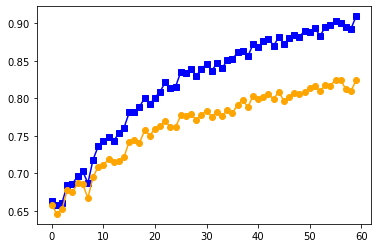

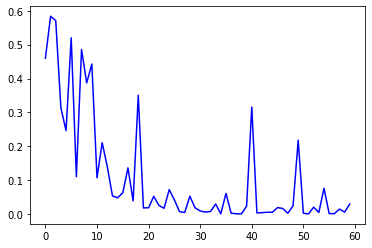

In [12]:
# resetParam(model_gpu)
train(model_gpu, "cnn_adam_dropout0.5", loader_train, loader_verify, loss_fn, optimizer, num_epochs = 60)
# train(model_gpu, loader_train,loader_verify, loss_fn, optimizer, num_epochs = 10)
# torch.save(model_gpu.state_dict(), os.getcwd()+"\\mode_gpu_state")
# check_accuracy(model_gpu, loader_verify)
# check_accuracy(model_gpu, loader_train)

## PyTorch Models 

### ResNet 50

In [13]:
ResNet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False, num_classes = 2)

gpu_dtype = torch.cuda.FloatTensor
ResNet50_gpu = ResNet50.type(gpu_dtype)    
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = torch.optim.Adam(ResNet50_gpu.parameters(), lr=1e-3) #weight_decay = 0.01

Using cache found in C:\Users\hower/.cache\torch\hub\pytorch_vision_v0.6.0


Starting epoch 1 / 20
t = 150, loss = 0.6216771603
t = 300, loss = 0.6264909506
t = 450, loss = 0.5220099688
Got 18249 / 29506 correct (61.85)
Got 6097 / 9835 correct (61.99)
Starting epoch 2 / 20
t = 150, loss = 0.6097398400
t = 300, loss = 0.6097928286
t = 450, loss = 0.5011798739
Got 19238 / 29506 correct (65.20)
Got 6359 / 9835 correct (64.66)
Starting epoch 3 / 20
t = 150, loss = 0.6046650410
t = 300, loss = 0.5572777390
t = 450, loss = 0.5232422352
Got 20049 / 29506 correct (67.95)
Got 6560 / 9835 correct (66.70)
Starting epoch 4 / 20
t = 150, loss = 0.5938668251
t = 300, loss = 0.5218331814
t = 450, loss = 0.4751499593
Got 18063 / 29506 correct (61.22)
Got 5983 / 9835 correct (60.83)
Starting epoch 5 / 20
t = 150, loss = 0.6241483092
t = 300, loss = 0.5129231811
t = 450, loss = 0.4888581038
Got 19890 / 29506 correct (67.41)
Got 6513 / 9835 correct (66.22)
Starting epoch 6 / 20
t = 150, loss = 0.6080009937
t = 300, loss = 0.4807399809
t = 450, loss = 0.3907108307
Got 20551 / 2950

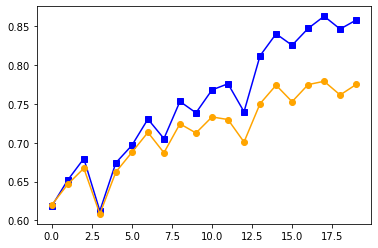

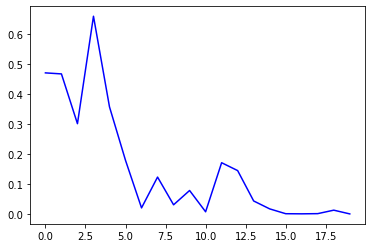

In [14]:
train(ResNet50_gpu, "ResNet50_adam_lr1e-3", loader_train, loader_verify, loss_fn, optimizer, num_epochs = 20)

### GoogLeNet

In [9]:
GoogLeNet = models.googlenet(pretrained=True)
gpu_dtype = torch.cuda.FloatTensor
GoogLeNet_gpu = GoogLeNet.type(gpu_dtype)    
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = torch.optim.RMSprop(GoogLeNet_gpu.parameters(), lr=5e-4) #weight_decay = 0.01

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\hower/.cache\torch\checkpoints\googlenet-1378be20.pth
47.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Starting epoch 1 / 20
t = 150, loss = 0.5427781343
t = 300, loss = 0.5296164155
t = 450, loss = 0.4924544096
Got 22283 / 29506 correct (75.52)
Got 7168 / 9835 correct (72.88)
Starting epoch 2 / 20
t = 150, loss = 0.4580561817
t = 300, loss = 0.3928819895
t = 450, loss = 0.3324690163
Got 17374 / 29506 correct (58.88)
Got 5745 / 9835 correct (58.41)
Starting epoch 3 / 20
t = 150, loss = 0.3895204961
t = 300, loss = 0.2723377347
t = 450, loss = 0.1980806887
Got 22315 / 29506 correct (75.63)
Got 7121 / 9835 correct (72.40)
Starting epoch 4 / 20
t = 150, loss = 0.2324678749
t = 300, loss = 0.2081545293
t = 450, loss = 0.1315183789
Got 23687 / 29506 correct (80.28)
Got 7460 / 9835 correct (75.85)
Starting epoch 5 / 20
t = 150, loss = 0.0830803737
t = 300, loss = 0.1348213255
t = 450, loss = 0.0711435527
Got 18981 / 29506 correct (64.33)
Got 6249 / 9835 correct (63.54)
Starting epoch 6 / 20
t = 150, loss = 0.0444020033
t = 300, loss = 0.1857239157
t = 450, loss = 0.0890966356
Got 23357 / 2950

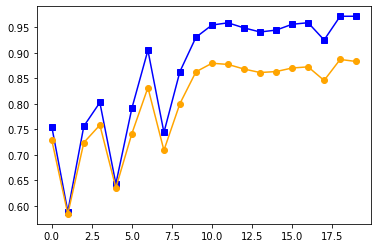

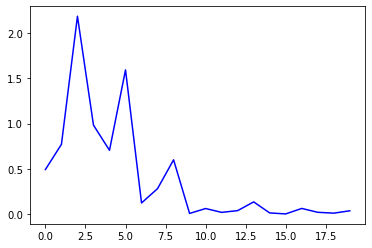

In [10]:
train(GoogLeNet_gpu, "GoogLeNet_RMSprop_lr5e-4", loader_train, loader_verify, loss_fn, optimizer, num_epochs = 20)